In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (15, 5)
mpl.rcParams['axes.grid'] = False

C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../CSI_Preprocessing/output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
# df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,2022-01-08 08:35:41.784772,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,2022-01-08 08:35:42.807257,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,2022-01-08 08:35:43.831145,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,2022-01-08 08:35:44.854967,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,2022-01-08 08:35:45.880211,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


<AxesSubplot:>

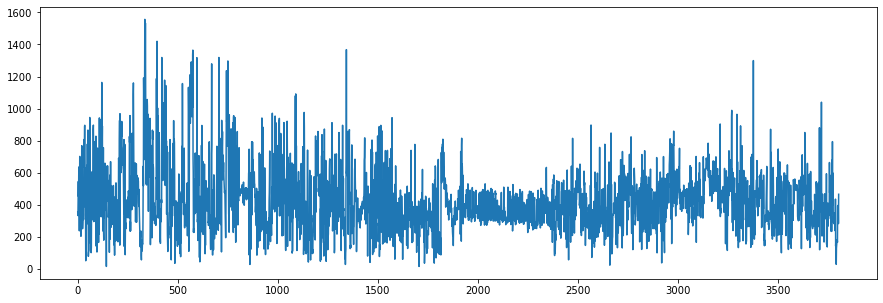

In [3]:
temp = df['Subcar_7']
temp.plot()

In [4]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [5]:
WINDOW_SIZE = 144
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((3658, 5, 1), (3658,))

In [6]:
x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]
print('x_train set:', x_train.shape)
print('y_train set:', y_train.shape)
print('x_test set:', x_test.shape)
print('y_test:', y_test.shape)
print('x_val set:', x_val.shape)
print('y_val set:', y_val.shape)

x_train set: (2000, 5, 1)
y_train set: (2000,)
x_test set: (50, 5, 1)
y_test: (50,)
x_val set: (2908, 5, 1)
y_val set: (2908,)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [8]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [9]:
cp = ModelCheckpoint('../save/model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [10]:
model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2000, callbacks=[cp])

Epoch 1/2000
43/63 [===================>..........] - ETA: 0s - loss: 242148.3438 - mean_absolute_error: 436.5234WARNING:tensorflow:From C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../save/model1\assets
63/63 [==============================] - 3s 51ms/step - loss: 246710.4375 - mean_absolute_error: 439.8794 - val_loss: 191020.8594 - val_mean_absolute_error: 405.6099
Epoch 2/2000
63/63 [==============================] - 3s 51ms/step - loss: 246090.5938 - mean_absolute_error: 439.1783 - val_loss: 190326.8281 - val_mean_absolute_error:

In [11]:
from tensorflow.keras.models import load_model
model1 = load_model('../save/model1/')

In [12]:
train_predictions1 = model1.predict(x_train).flatten()
train_results1 = pd.DataFrame(data={'Train Predictions': train_predictions1, 'Actuals': y_train})
train_results1

,Train Predictions,Actuals
0,425.934814,587.749096
1,509.069153,635.824661
2,457.887451,360.188839
3,472.148865,237.118114
4,338.052155,507.607132
...,...,...
1995,340.351685,321.810503
1996,346.390137,366.890992
1997,371.474884,323.975308
1998,347.515930,329.789327


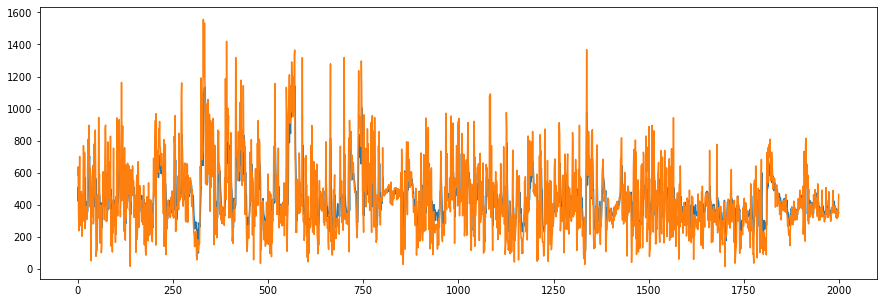

In [13]:
plt.plot(train_results1['Train Predictions'])
plt.plot(train_results1['Actuals'])

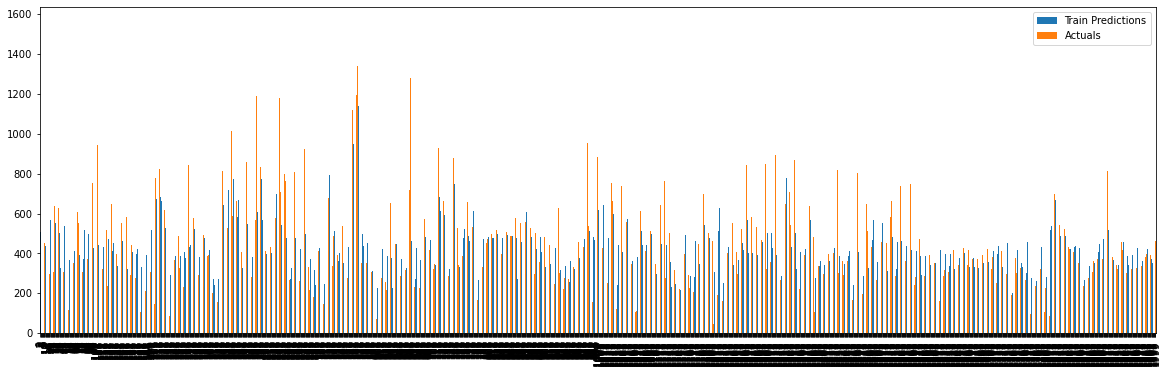

In [14]:
fig,ax = plt.subplots(figsize=(20,6))
train_results1.plot(kind='bar',ax=ax)
plt.show()

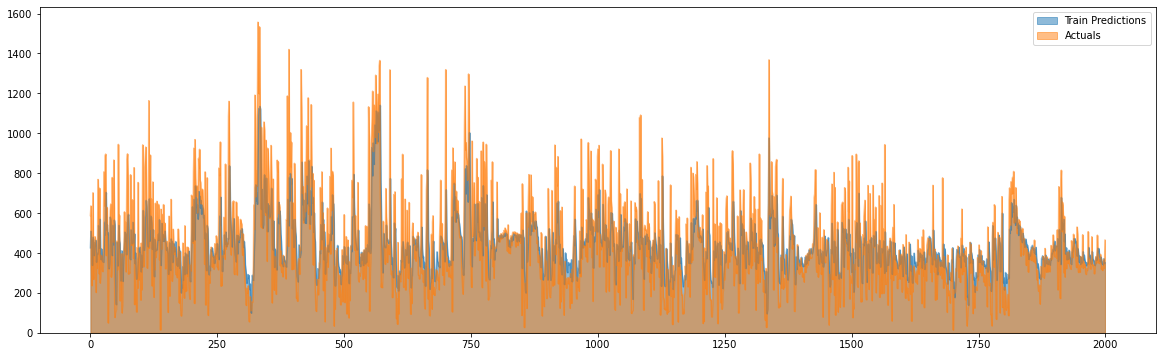

In [15]:
fig,ax = plt.subplots(figsize=(20,6))
train_results1.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [16]:
val_predictions1 = model1.predict(x_val).flatten()
val_results1 = pd.DataFrame(data={'Val predictions': val_predictions1, 'Actuals': y_val})
val_results1

,Val predictions,Actuals
0,466.953735,340.834271
1,402.437195,228.319951
2,331.295380,961.095729
3,466.359100,484.530701
4,473.887329,535.452145
...,...,...
2903,315.508484,381.808853
2904,403.887878,278.167216
2905,361.987610,195.205020
2906,257.411987,607.356567


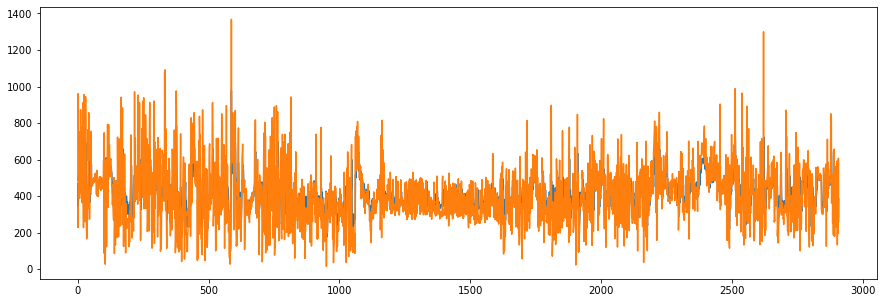

In [17]:
plt.plot(val_results1['Val predictions'])
plt.plot(val_results1['Actuals'])

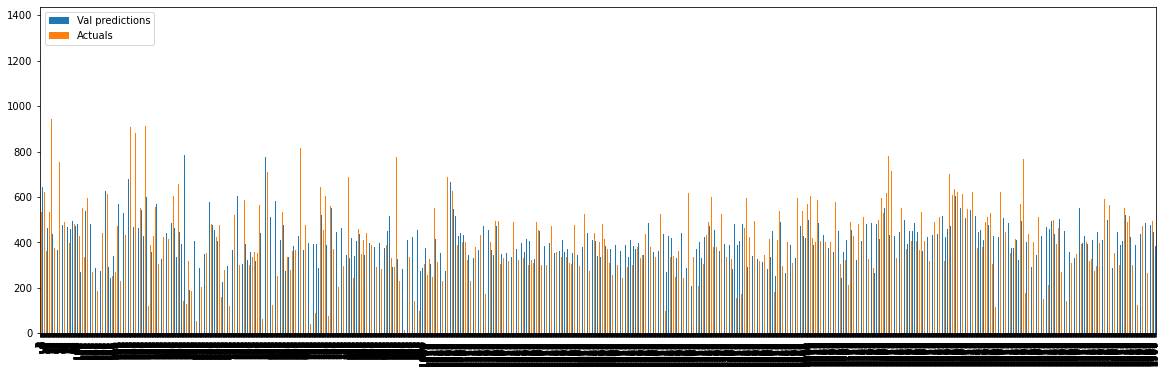

In [18]:
fig,ax = plt.subplots(figsize=(20,6))
val_results1.plot(kind='bar',ax=ax)
plt.show()

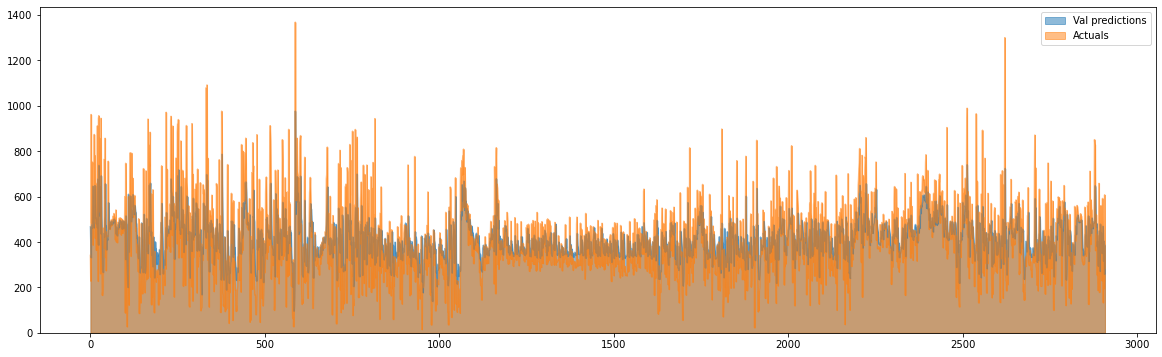

In [19]:
fig,ax = plt.subplots(figsize=(20,6))
val_results1.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [20]:
test_predictions1 = model1.predict(x_test).flatten()
test_results1 = pd.DataFrame(data={'Test predictions': test_predictions1, 'Actuals': y_test})
test_results1

,Test predictions,Actuals
0,468.678986,1318.891959
1,716.622864,427.907700
2,469.154877,308.974109
3,428.492371,375.431751
4,388.334656,315.995253
5,379.127350,323.487249
6,344.445679,281.128085
7,332.677307,346.161812
8,360.825226,294.266886
9,341.636536,291.756748


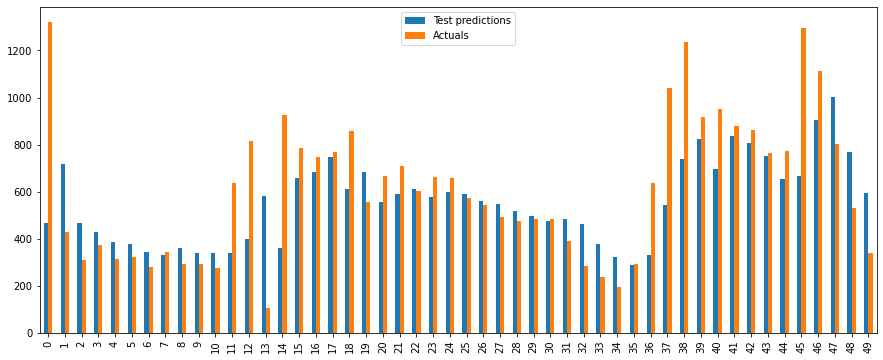

In [21]:
fig,ax = plt.subplots(figsize=(15,6))
test_results1.plot(kind='bar',ax=ax)
plt.show()

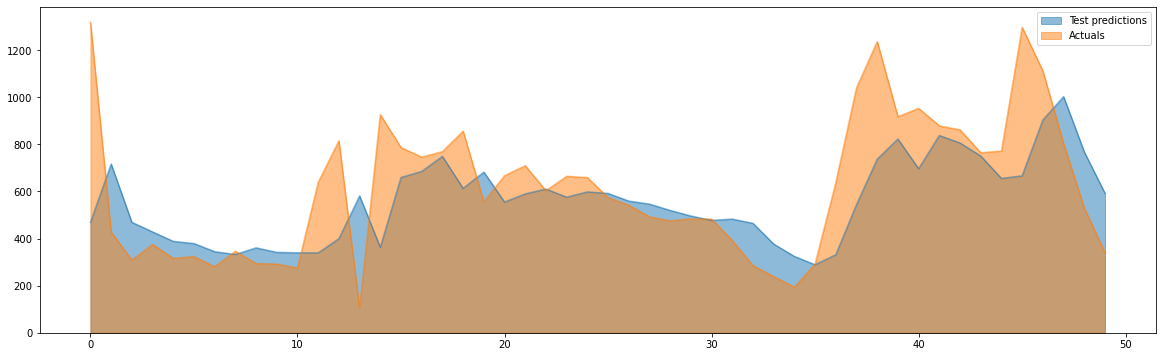

In [22]:
fig,ax = plt.subplots(figsize=(20,6))
test_results1.plot(kind='area',ax=ax,stacked=False)
plt.show()

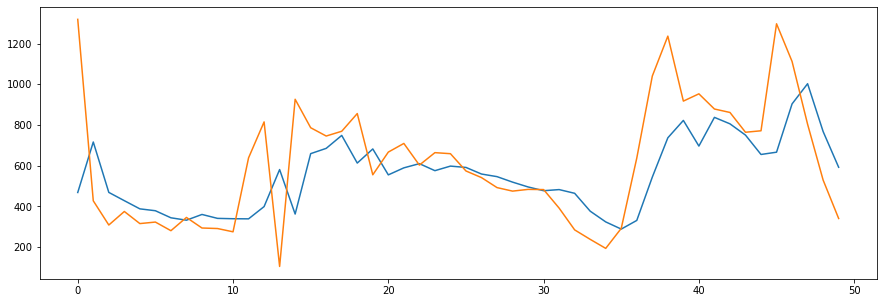

In [23]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])

In [24]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [25]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [26]:
cp2 = ModelCheckpoint('../save/model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [27]:
model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2000, callbacks=[cp2])

Epoch 1/2000
63/63 [==============================] - 1s 9ms/step - loss: 199245.2812 - mean_absolute_error: 386.8231 - val_loss: 117428.5312 - val_mean_absolute_error: 306.3386
Epoch 2/2000
63/63 [==============================] - 0s 8ms/step - loss: 117733.3828 - mean_absolute_error: 279.6596 - val_loss: 62169.0078 - val_mean_absolute_error: 208.5059
Epoch 3/2000
63/63 [==============================] - 0s 8ms/step - loss: 70757.6953 - mean_absolute_error: 204.2805 - val_loss: 37157.0625 - val_mean_absolute_error: 149.8039
Epoch 4/2000
63/63 [==============================] - 1s 8ms/step - loss: 51672.1836 - mean_absolute_error: 167.9313 - val_loss: 28633.2773 - val_mean_absolute_error: 124.6004
Epoch 5/2000
63/63 [==============================] - 1s 8ms/step - loss: 46157.2812 - mean_absolute_error: 156.0702 - val_loss: 26476.4355 - val_mean_absolute_error: 117.9316
Epoch 6/2000
63/63 [==============================] - 1s 8ms/step - loss: 44952.6602 - mean_absolute_error: 153.7710 

In [28]:
from tensorflow.keras.models import load_model
model2 = load_model('../save/model2/')

In [29]:
train_predictions2 = model2.predict(x_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y_train})
train_results2

,Train Predictions,Actuals
0,440.816071,587.749096
1,490.754456,635.824661
2,525.977417,360.188839
3,437.027924,237.118114
4,348.217682,507.607132
...,...,...
1995,350.158844,321.810503
1996,350.728699,366.890992
1997,366.595795,323.975308
1998,356.801849,329.789327


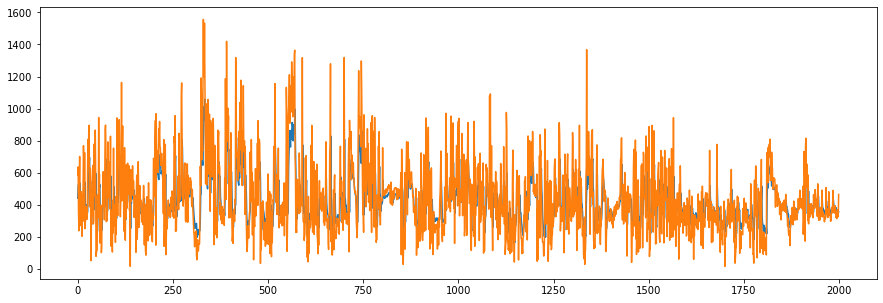

In [30]:
plt.plot(train_results2['Train Predictions'])
plt.plot(train_results2['Actuals'])

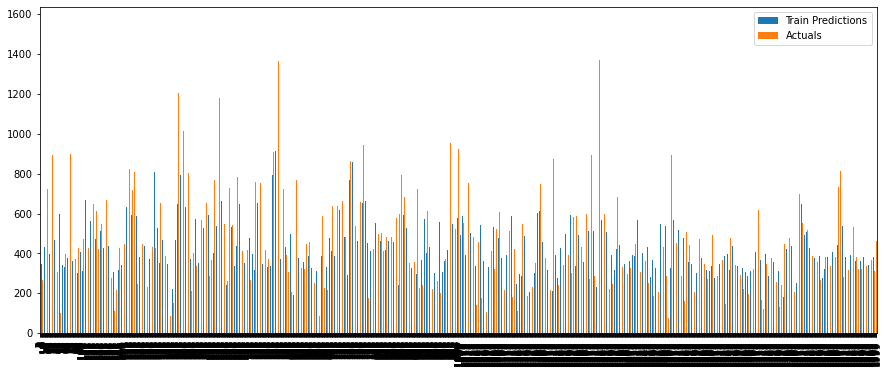

In [31]:
fig,ax = plt.subplots(figsize=(15,6))
train_results2.plot(kind='bar',ax=ax)
plt.show()

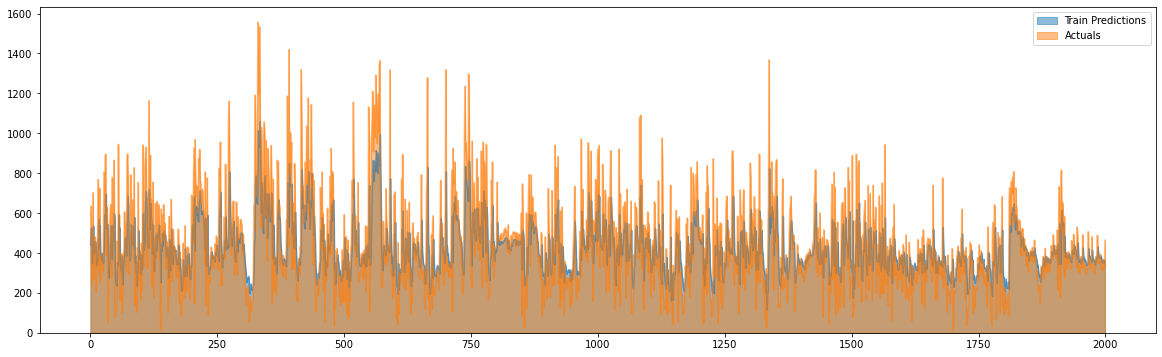

In [32]:
fig,ax = plt.subplots(figsize=(20,6))
train_results2.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [33]:
val_predictions2 = model2.predict(x_val).flatten()
val_results2 = pd.DataFrame(data={'Val predictions': val_predictions2, 'Actuals': y_val})
val_results2

,Val predictions,Actuals
0,461.991547,340.834271
1,408.410675,228.319951
2,336.278168,961.095729
3,604.661621,484.530701
4,497.234131,535.452145
...,...,...
2903,308.592346,381.808853
2904,365.039368,278.167216
2905,337.660187,195.205020
2906,303.426025,607.356567


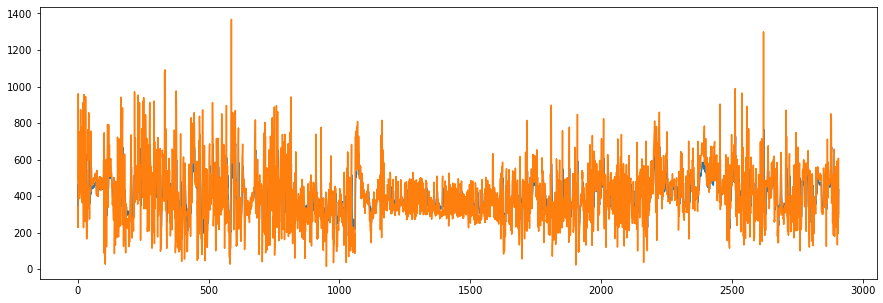

In [34]:
plt.plot(val_results2['Val predictions'])
plt.plot(val_results2['Actuals'])

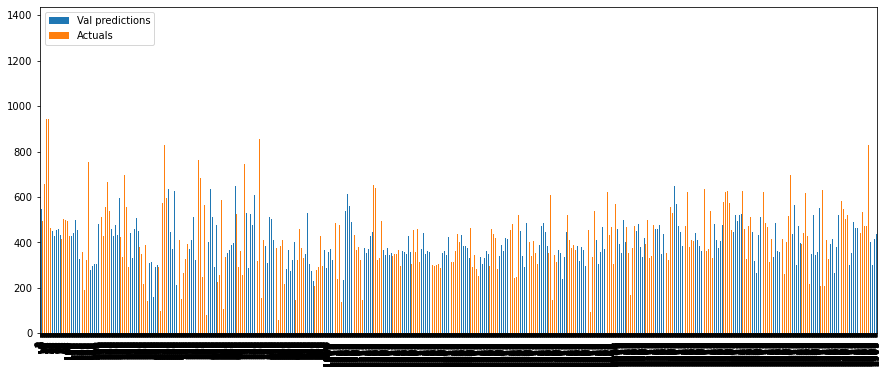

In [35]:
fig,ax = plt.subplots(figsize=(15,6))
val_results2.plot(kind='bar',ax=ax)
plt.show()

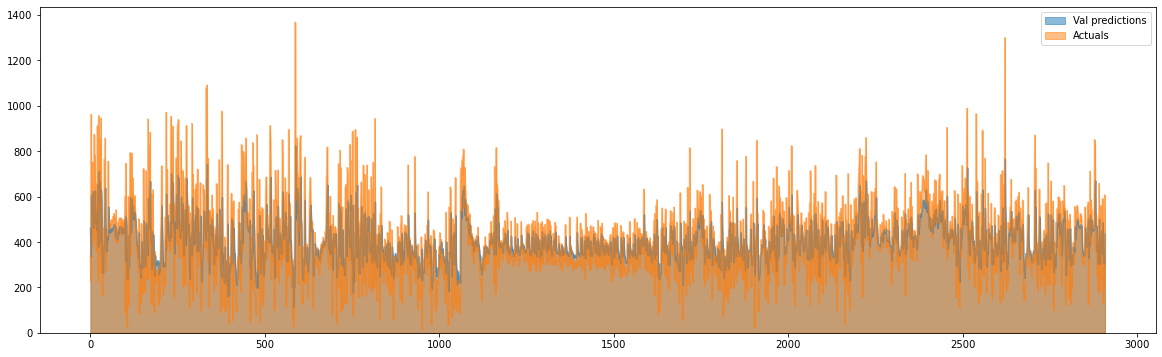

In [36]:
fig,ax = plt.subplots(figsize=(20,6))
val_results2.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [37]:
test_predictions2 = model2.predict(x_test).flatten()
test_results2 = pd.DataFrame(data={'Test predictions': test_predictions2, 'Actuals': y_test})
test_results2

,Test predictions,Actuals
0,488.559113,1318.891959
1,807.574585,427.907700
2,444.389435,308.974109
3,434.848114,375.431751
4,388.332184,315.995253
5,397.125336,323.487249
6,357.657379,281.128085
7,331.855347,346.161812
8,355.860138,294.266886
9,338.189209,291.756748


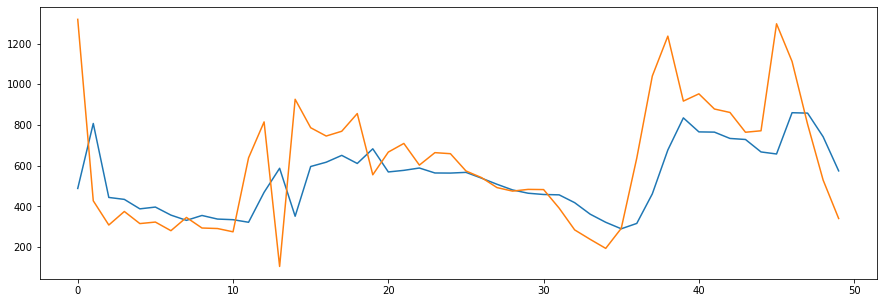

In [38]:
plt.plot(test_results2['Test predictions'])
plt.plot(test_results2['Actuals'])

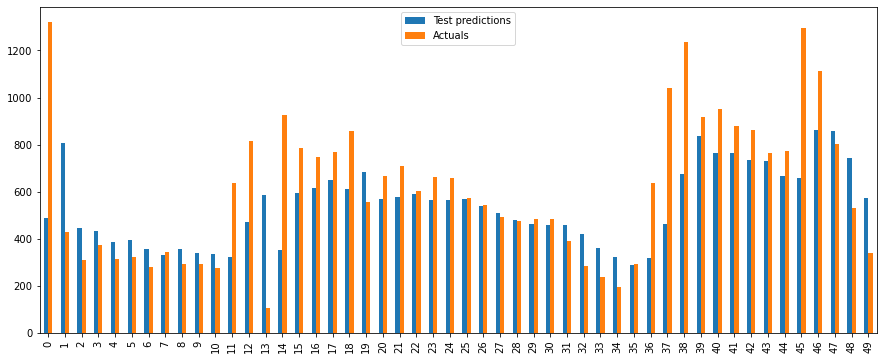

In [39]:
fig,ax = plt.subplots(figsize=(15,6))
test_results2.plot(kind='bar',ax=ax)
plt.show()

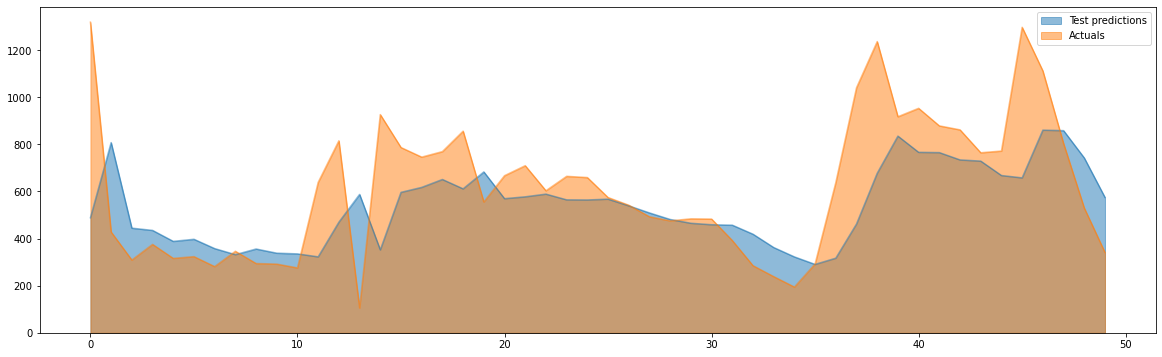

In [40]:
fig,ax = plt.subplots(figsize=(20,6))
test_results2.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [41]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [42]:
cp3 = ModelCheckpoint('../save/model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [43]:
model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2000, callbacks=[cp3])

Epoch 1/2000
63/63 [==============================] - 3s 44ms/step - loss: 247672.2031 - mean_absolute_error: 440.9792 - val_loss: 191860.6875 - val_mean_absolute_error: 406.6456
Epoch 2/2000
63/63 [==============================] - 3s 42ms/step - loss: 247282.4219 - mean_absolute_error: 440.5329 - val_loss: 191738.1250 - val_mean_absolute_error: 406.4893
Epoch 3/2000
63/63 [==============================] - 3s 54ms/step - loss: 247220.5625 - mean_absolute_error: 440.4589 - val_loss: 191692.5000 - val_mean_absolute_error: 406.4327
Epoch 4/2000
63/63 [==============================] - 3s 43ms/step - loss: 247165.0938 - mean_absolute_error: 440.3952 - val_loss: 191628.6719 - val_mean_absolute_error: 406.3545
Epoch 5/2000
63/63 [==============================] - 3s 40ms/step - loss: 247097.7969 - mean_absolute_error: 440.3191 - val_loss: 191565.8438 - val_mean_absolute_error: 406.2769
Epoch 6/2000
63/63 [==============================] - 3s 44ms/step - loss: 247016.6875 - mean_absolute_er

In [44]:
train_predictions3 = model3.predict(x_train).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions': train_predictions3, 'Actuals': y_train})
train_results3

,Train Predictions,Actuals
0,440.241119,587.749096
1,480.394745,635.824661
2,485.815491,360.188839
3,442.086945,237.118114
4,318.723724,507.607132
...,...,...
1995,366.282990,321.810503
1996,357.373993,366.890992
1997,372.068237,323.975308
1998,379.654083,329.789327


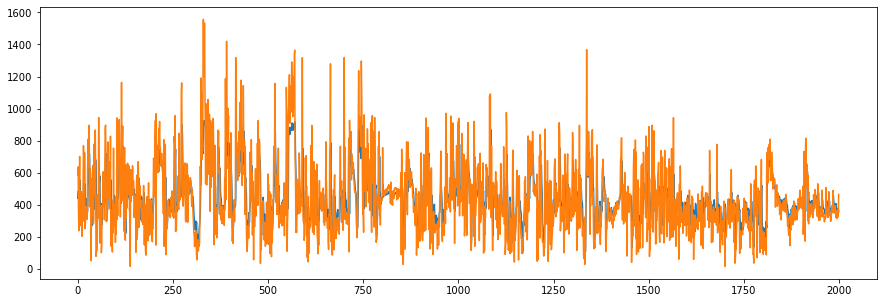

In [45]:
plt.plot(train_results3['Train Predictions'])
plt.plot(train_results3['Actuals'])

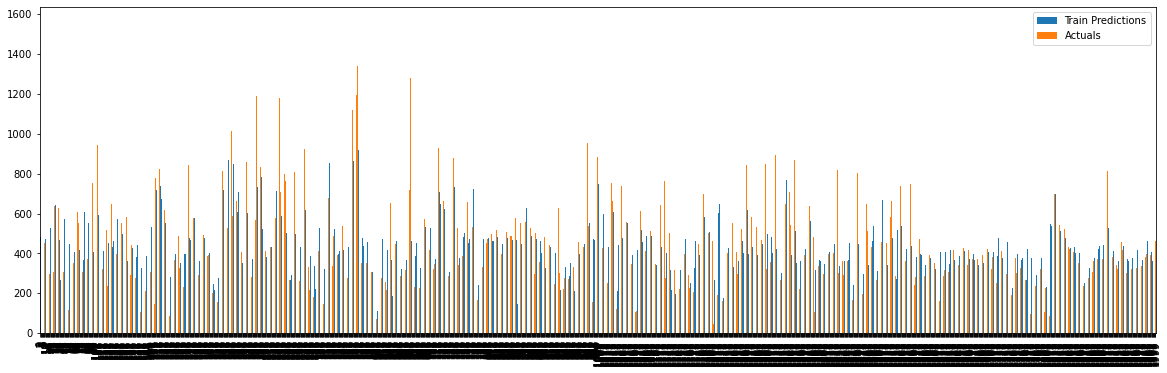

In [46]:
fig,ax = plt.subplots(figsize=(20,6))
train_results3.plot(kind='bar',ax=ax)
plt.show()

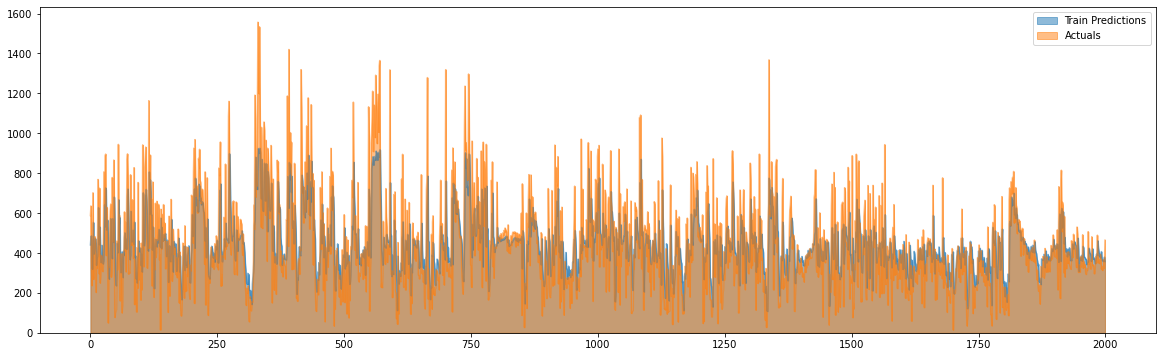

In [47]:
fig,ax = plt.subplots(figsize=(20,6))
train_results3.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [48]:
val_predictions3 = model3.predict(x_val).flatten()
val_results3 = pd.DataFrame(data={'Val predictions': val_predictions3, 'Actuals': y_val})
val_results3

,Val predictions,Actuals
0,547.563171,340.834271
1,397.481628,228.319951
2,376.551056,961.095729
3,543.410645,484.530701
4,415.745392,535.452145
...,...,...
2903,298.471161,381.808853
2904,371.889252,278.167216
2905,358.692047,195.205020
2906,364.650482,607.356567


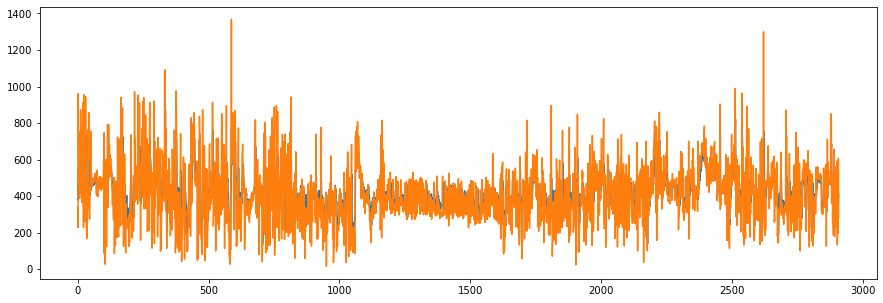

In [49]:
plt.plot(val_results3['Val predictions'])
plt.plot(val_results3['Actuals'])

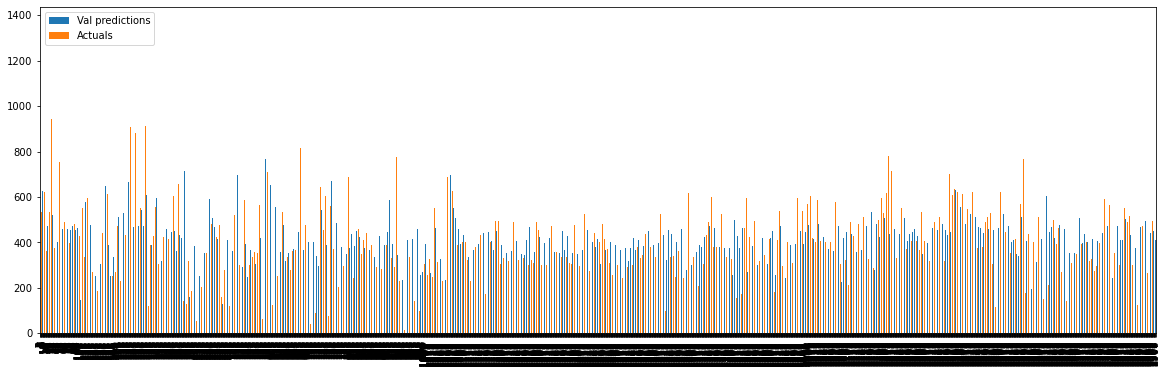

In [50]:
fig,ax = plt.subplots(figsize=(20,6))
val_results3.plot(kind='bar',ax=ax)
plt.show()

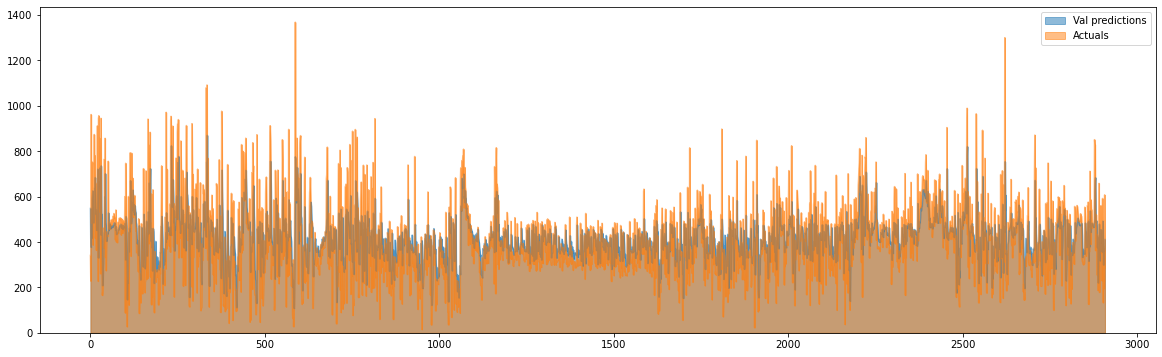

In [51]:
fig,ax = plt.subplots(figsize=(20,6))
val_results3.plot(kind='area',ax=ax,stacked=False)
plt.show()

In [52]:
test_predictions3 = model3.predict(x_test).flatten()
test_results3 = pd.DataFrame(data={'Test predictions': test_predictions3, 'Actuals': y_test})
test_results3

,Test predictions,Actuals
0,527.677979,1318.891959
1,761.247864,427.907700
2,485.229889,308.974109
3,477.417572,375.431751
4,353.818970,315.995253
5,428.767883,323.487249
6,356.824615,281.128085
7,360.150909,346.161812
8,357.811737,294.266886
9,373.557037,291.756748


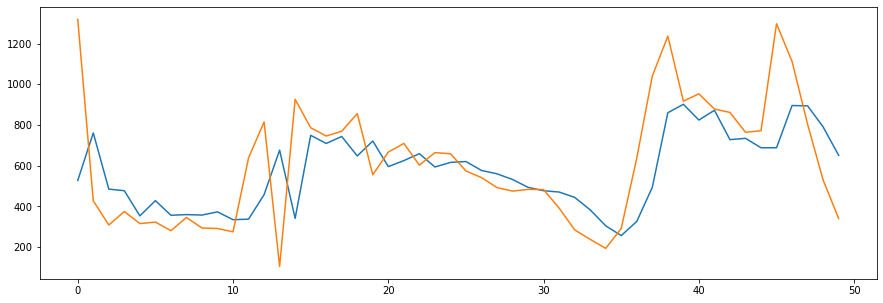

In [53]:
plt.plot(test_results3['Test predictions'])
plt.plot(test_results3['Actuals'])

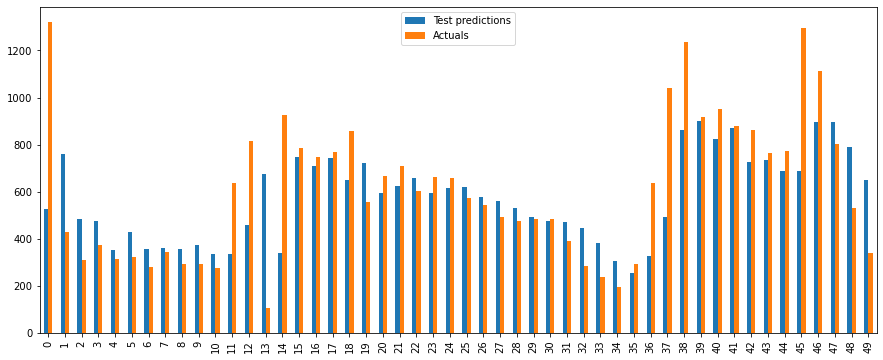

In [54]:
fig,ax = plt.subplots(figsize=(15,6))
test_results3.plot(kind='bar',ax=ax)
plt.show()

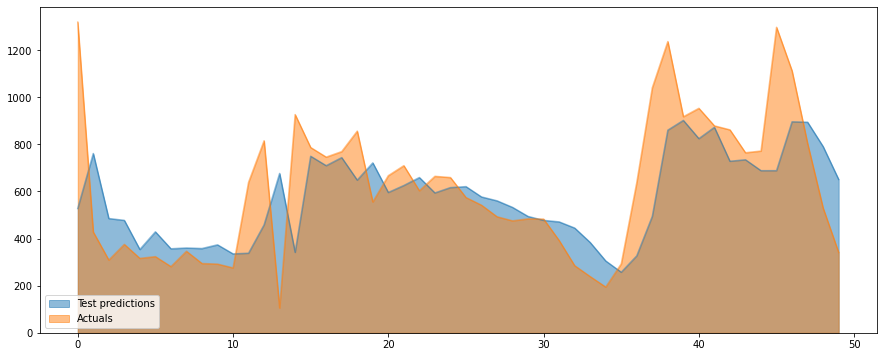

In [55]:
fig,ax = plt.subplots(figsize=(15,6))
test_results3.plot(kind='area',ax=ax,stacked=False)
plt.show()